# Node assortativity coefficients and correlation measures

In this tutorial, we will go through the theory of [assortativity](https://en.wikipedia.org/wiki/Assortativity) and its measures.

Specifically, we'll focus on assortativity measures available in NetworkX at [algorithms/assortativity/correlation.py](https://github.com/networkx/networkx/blob/main/networkx/algorithms/assortativity/correlation.py):
* Attribute assortativity
* Numeric assortativity
* Degree assortativity

as well as mixing matrices, which are closely releated to assortativity measures.

## Assortativity

Assortativity in a network refers to the tendency of nodes to connect with
other 'similar' nodes over 'dissimilar' nodes.

Here we say that two nodes are 'similar' with respect to a property if they have the same value of that property. Properties can be any structural properties like the degree of a node to other properties like weight, or capacity.

Based on these properties we can have a different measure of assortativity for the network.
On the other hand, we can also have disassortativity, in which case nodes tend
to connect to dissimilar nodes over similar nodes.

### Assortativity coefficients

Let's say we have a network $N$, $N = (V, E)$  where $V$ is the set of nodes in the network and $E$ is the set of edges/directed edges in the network.
In addition, $P(v)$ represents a property for each node $v$.

#### Mixing matrix

Let the property $P(v)$ take $P[0],P[1],...P[k-1]$ distinct values on the network,
then the **mixing matrix** is matrix $M$ such that $M[i][j]$ represents the number of edges from
nodes with property $P[i]$ to $P[j]$.
We can normalize mixing matrix by diving by total number of ordered edges i.e.
$ e = \frac{M}{|E|}$.

Now define,

$a[i]=$ proportion of edges $(u,v)$ such that $P(u)=P[i]$

$$ a[i] = \sum\limits_{j}e[i][j] $$

$b[i]=$ proportion of edges $(u,v)$ such that $P(v)=P[i]$

$$ b[i] = \sum\limits_{j}e[j][i]$$

in Python code it would look something like `a = e.sum(axis=0)` and `b = e.sum(axis=1)`

Finally, let $\sigma_a$ and $\sigma_b$ represent the standard deviation of
$\{\ P[i]\cdot a[i]\ |\ i \in 0...k-1\}$ and $\{ P[i]\cdot b[i]\ |\ i \in 0...k-1\}$
respectively.

Then we can define the assortativity coefficient for this property based on the
Pearson correlation coefficient.

#### Attribute Assortativity Coefficient

Here the property $P(v)$ is a nominal property assigned to each node.
As defined above we calculate the normalized mixing matrix $e$ and from that we
define the attribute assortativity coefficient [^1] as below.

From here onwards we will use subscript notation to denote indexing, for eg. $P_i = P[i]$ and $e_{ij} = e[i][j]$

$$ r = \frac{\sum\limits_{i}e_{ii} - \sum\limits_{i}a_{i}b_{i}}{1-\sum\limits_{i}a_{i}b_{i}} = \frac{Trace(e) - ||e^2||}{1-||e^2||}$$

It is implemented as `attribute_assortativity_coefficient`.

#### Numeric Assortativity Coefficient

Here the property $P(v)$ is a numerical property assigned to each
node and the definition of the normalized mixing
matrix $e$, $\sigma_a$, and $\sigma_b$ are same as above.
From these we define numeric assortativity coefficient [^1] as below.

$$ r = \frac{\sum\limits_{i,j}P_i P_j(e_{ij} -a_i b_j)}{\sigma_a\sigma_b} $$

It is implemented as `numeric_assortativity_coefficient`.

#### Degree Assortativity Coefficient

When it comes to measuring degree assortativity for directed networks we have
more options compared to assortativity w.r.t a property because we have 2 types
of degrees, namely in-degree and out-degree.
Based on the 2 types of degrees we can measure $2 \times 2 =4$ different types
of degree assortativity [^2]:

1. r(in,in) : Measures tendency of having a directed edge (u,v) such that, in-degree(u) = in-degree(v).
2. r(in,out) : Measures tendency of having a directed edge (u,v) such that, in-degree(u) = out-degree(v).
3. r(out,in) : Measures tendency of having a directed edge (u,v) such that, out-degree(u) = in-degree(v).
4. r(out,out) : Measures tendency of having a directed edge (u,v) such that, out-degree(u) = out-degree(v).

Note: If the network is undirected all the 4 types of degree assortativity are the same.

To define the degree assortativity coefficient for all 4 types we need slight
modification in the definition of $P[i]$ and $e$, and the definations of
$\sigma_a$ and $\sigma_b$ remain the same.

Let $x,y \in \{in,out\}$. The property $P(\cdot)$ takes distinct values from
the union of the values taken by $x$-degree$(\cdot)$ and $y$-degree$(\cdot)$,
and $e_{i,j}$ is the proportion of directed edges $(u,v)$ with $x$-degree$(u) = P_i$
and $y$-degree$(v) = P_j$.

$$ r(x,y) = \frac{\sum\limits_{i,j}P_i P_j(e_{ij} -a_i b_j)}{\sigma_a\sigma_b} $$

It is implemented as `degree_assortativity_coefficient` and
`degree_pearson_correlation_coefficient`. The latter function uses
`scipy.stats.pearsonr` to calculate the assortativity coefficient which makes
it potentally faster.

## Example

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import random
import warnings
warnings.filterwarnings("ignore")

Illustrating how value of assortativity changes

In [2]:
gname = "g2"
# loading the graph
G = nx.read_graphml(f"data/{gname}.graphml")
with open(f"data/pos_{gname}", "rb") as fp:
    pos = pickle.load(fp)

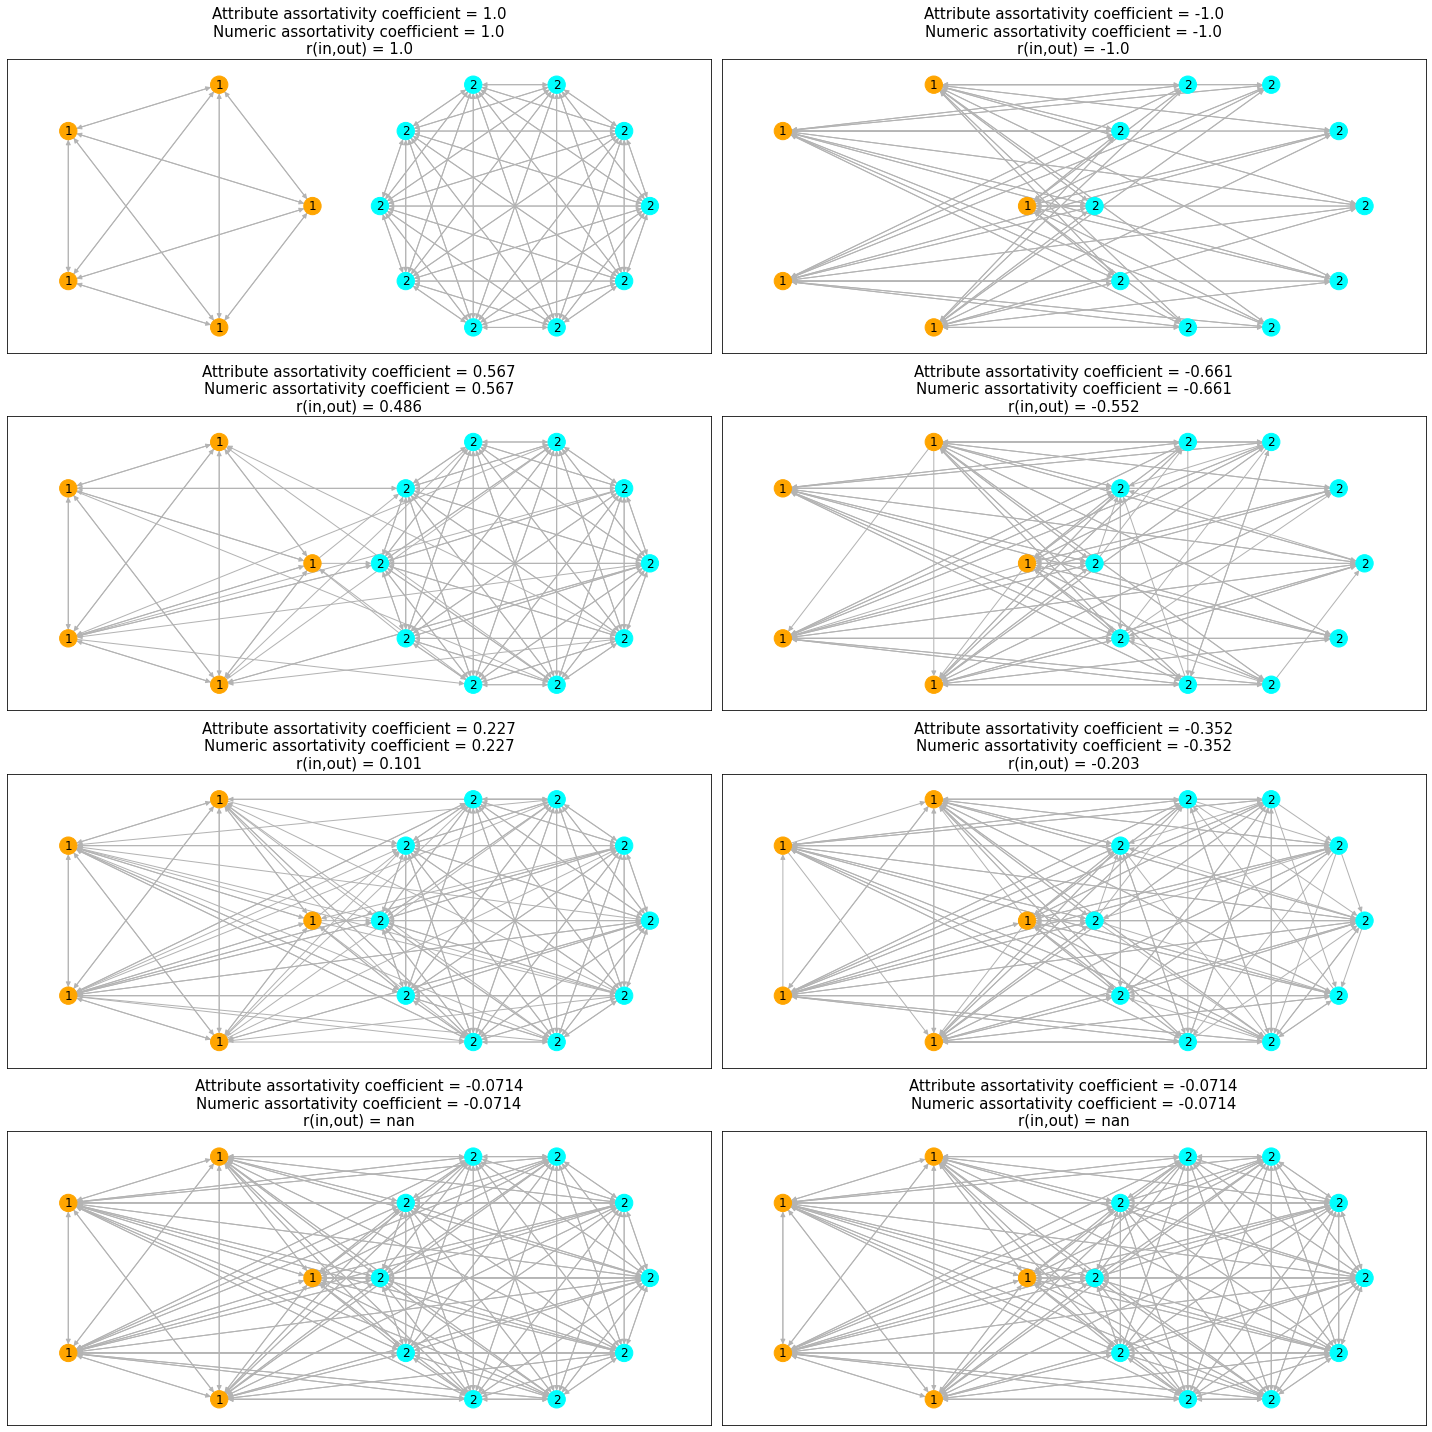

In [3]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

# assign colors and labels to nodes based on their 'cluster' and 'num_prop' property
node_colors = ["orange" if G.nodes[u]["cluster"] == "K5" else "cyan" for u in G.nodes]
node_labels = {u: G.nodes[u]["num_prop"] for u in G.nodes}

for i in range(8):
    g = nx.read_graphml(f"data/{gname}_{i}.graphml")

    # calculating the assortativity coefficients wrt different proeprties
    cr = nx.attribute_assortativity_coefficient(g, "cluster")
    r_in_out = nx.degree_assortativity_coefficient(g, x="in", y="out")
    nr = nx.numeric_assortativity_coefficient(g, "num_prop")

    # drawing the network
    nx.draw_networkx_nodes(
        g, pos=pos, node_size=300, ax=axes[i // 2][i % 2], node_color=node_colors
    )
    nx.draw_networkx_labels(g, pos=pos, labels=node_labels, ax=axes[i // 2][i % 2])
    nx.draw_networkx_edges(g, pos=pos, ax=axes[i // 2][i % 2], edge_color="0.7")
    axes[i // 2][i % 2].set_title(
        f"Attribute assortativity coefficient = {cr:.3}\nNumeric assortativity coefficient = {nr:.3}\nr(in,out) = {r_in_out:.3}",
        size=15,
    )

fig.tight_layout()

Nodes are colored by the `cluster` property and labeled by `num_prop` property.
We can observe that the initial network on the left side is completely assortative
and its complement on right side is completely disassortative.
As we add edges between nodes of different (similar) attributes in the assortative
(disassortative) network, the network tends to a non-assortative network and
value of both the assortativity coefficients tends to $0$.

The parameter `nodes` in `attribute_assortativity_coefficient` and
`numeric_assortativity_coefficient` specifies the nodes whose edges are to be
considered in the mixing matrix calculation.
That is to say, if $(u,v)$ is a directed edge then the edge $(u,v)$ will be
used in mixing matrix calculation if $u$ is in `nodes`.
For the undirected case, it's considered if atleast one of the $u,v$ in in `nodes`.

The `nodes` parameter is interpreted differently in `degree_assortativity_coefficient` and
`degree_pearson_correlation_coefficient`, where it specifies the nodes forming a subgraph
whose edges are considered in the mixing matrix calculation.

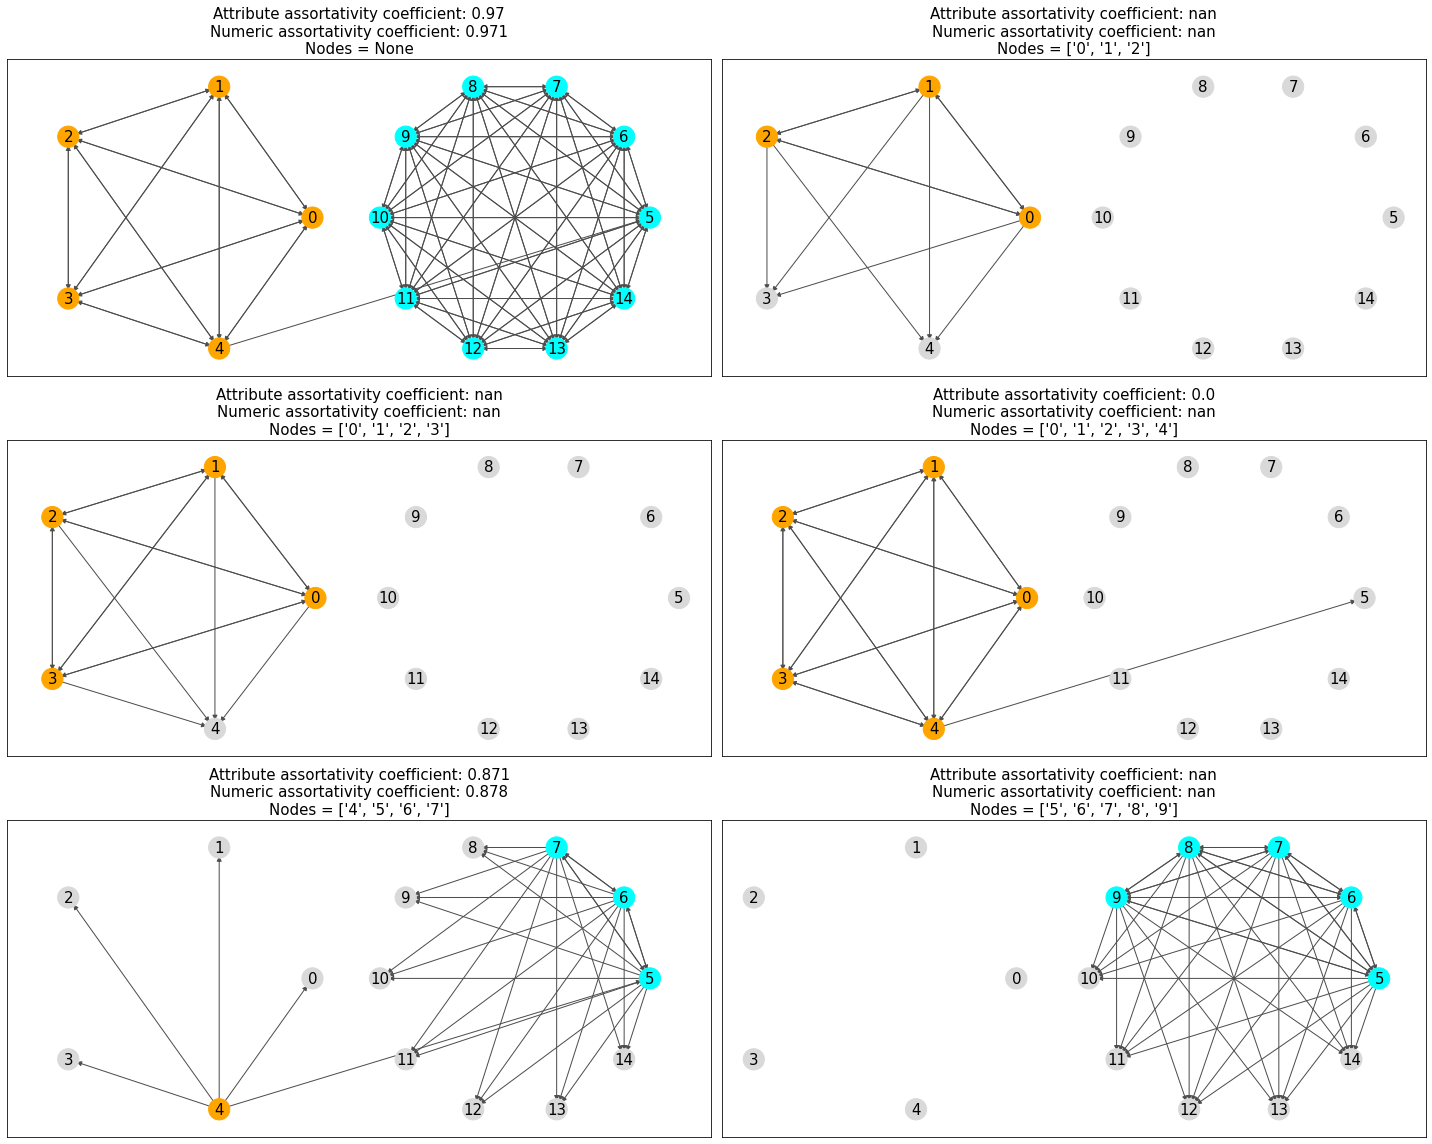

In [4]:
# list of nodes to consider for the i'th network in the example
# Note: passing 'None' means to consider all the nodes
nodes_list = [
    None,
    [str(i) for i in range(3)],
    [str(i) for i in range(4)],
    [str(i) for i in range(5)],
    [str(i) for i in range(4, 8)],
    [str(i) for i in range(5, 10)],
]
fig, axes = plt.subplots(3, 2, figsize=(20, 16))


def color_node(u, nodes):
    """Utility function to give the color of a node based on its attribute"""
    if u not in nodes:
        return "0.85"
    if G.nodes[u]["cluster"] == "K5":
        return "orange"
    else:
        return "cyan"


# adding a edge to show edge cases
G.add_edge("4", "5")

for nodes, ax in zip(nodes_list, axes.ravel()):
    # calculating the value of assortativity
    cr = nx.attribute_assortativity_coefficient(G, "cluster", nodes=nodes)
    nr = nx.numeric_assortativity_coefficient(G, "num_prop", nodes=nodes)

    # drawing network
    ax.set_title(
        f"Attribute assortativity coefficient: {cr:.3}\nNumeric assortativity coefficient: {nr:.3}\nNodes = {nodes}",
        size=15,
    )
    if nodes is None:
        nodes = [u for u in G.nodes()]
    node_colors = [color_node(u, nodes) for u in G.nodes]
    nx.draw_networkx_nodes(G, pos=pos, node_size=450, ax=ax, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, labels={u: u for u in G.nodes}, font_size=15, ax=ax)
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=[(u, v) for u, v in G.edges if u in nodes],
        ax=ax,
        edge_color="0.3",
    )
fig.tight_layout()

In the above plots only the nodes which are considered are colored and rest are
grayed out and only the edges which are considerd in the assortaivty calculation
are drawn.

[^1]: M. E. J. Newman, Mixing patterns in networks <https://doi.org/10.1103/PhysRevE.67.026126>

[^2]: Foster, J.G., Foster, D.V., Grassberger, P. & Paczuski, M. Edge direction and the structure of networks <https://doi.org/10.1073/pnas.0912671107>